# Emulation of Kessler Microphysics Scheme
### Here, we emulate the popular Kessler Microphysics Scheme (KMP) using Deep Neural Networks (DNNs). The Data consists of 24 million input/output samples gathered from an ORNL numeric weather model. The emulator consists of a classifier model and regression model. The first section of code loads the dataset and gives some basic statics of the for it. The four variables of interest are:

* ### Potential Temperature (theta)
* ### cloud water mixing ratio (qc)
* ### water vapor mixing ratio (qv)
* ### rain water mixing ratio (qr)

### For a description of these variables, please refer to the report. 

### The second section of the notebook calculates the number of 'operation and 'no-operation' samples in the dataset and identifies them. These are samples where there is neglibable change when comparing input and outputs.  We explore how the composition of op and no-op samples in the dataset affects the models. The last section of thenotebook defines the models and runs them. The emulator consists of a classification model to identify op samples and a regressor to predict the output of the scheme for each sample.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import seaborn as sb
import math

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [8]:
#load dataset, change 'path' as needed
path='/gpfs/alpine/cli900/world-shared/users/zaneb/microPhys/kessler_ml_data_flat.nc'
ds=nc.Dataset(path)
#prints variable names and dimensions
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_theta(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qc(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qv(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qr(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_rho_dry(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_z(nsamples)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_exner(nsamples, three)
    _

### The following is a function to identify operation and no-operation samples. A no-operation sample is where there is no difference between a samples inputs and outputs. Formally, we define a no-operation sample to be one which satifies:

MAX(|theta_in-theta_out |, |qc_in-qc_out|, |qv_in-qv_out|, |qr_in-qr_out|)< 1e-16

### That is, no variable changes to the 16th decimal place.  These no-op samples can contaminate the regression model. For this reason, the emulator consists of a classifier and regression model.

In [9]:
def dataOp2(theta_in, theta_out, qv_in, qv_out, qc_in, qc_out, qr_in, qr_out, delta):
    #Function to identify op/no-op values and identify them with boolean
    #returns two lists of booleans
    
    print("Inside dataOp2() with delta value of", delta)
    
    lenData=len(theta_in)
    opmask = np.zeros(lenData, dtype=bool)
    nopmask = np.zeros(lenData, dtype=bool)
    opcount=0
    nopcount=0
    
    for i in range(lenData):
        if ( np.abs(theta_in[i]-theta_out[i]) > delta ) or \
           ( np.abs(qv_in[i]-qv_out[i]) > delta ) or \
           ( np.abs(qc_in[i]-qc_out[i]) > delta ) or \
           ( np.abs(qr_in[i]-qr_out[i]) > delta ):
            opcount+=1
            opmask[i] = True
    

    for i in range(lenData):
        if ( np.abs(theta_in[i]-theta_out[i]) < delta ) and \
           ( np.abs(qv_in[i]-qv_out[i]) < delta ) and \
           ( np.abs(qc_in[i]-qc_out[i]) < delta ) and \
           ( np.abs(qr_in[i]-qr_out[i]) < delta ):
            nopcount+=1
            nopmask[i] = True
    print('operation samples:', opcount,'-----no operation samples:', nopcount,'-----total number of samples:', opcount+nopcount)
    
    print('--------------------------------Total no-op Variable sums-----------------------------')
    print( "[qc]-----in: ", np.sum(np.abs(qc_in[nopmask])),'-----out:', np.sum(np.abs(qc_out[nopmask])) )
    print( "[qv]-----in: ", np.sum(np.abs(qv_in[nopmask])),'-----out:', np.sum(np.abs(qv_out[nopmask])) )
    print( "[qr]-----in: ", np.sum(np.abs(qr_in[nopmask])),'-----out:', np.sum(np.abs(qr_out[nopmask])) )

    print('---------------------------------Total change in no-op variables------------------------')
    print( "[dqc] ", np.sum( np.abs(qc_in[nopmask] - qc_out[nopmask]) ) )
    print( "[dqv] ", np.sum( np.abs(qv_in[nopmask] - qv_out[nopmask]) ) )
    print( "[dqr] ", np.sum( np.abs(qr_in[nopmask] - qr_out[nopmask]) ) )

    print('--------------------------------Total op Variable sums----------------------------------')
    print( "[qc]-----in: ", np.sum(np.abs(qc_in[opmask])),'-----out:', np.sum(np.abs(qc_out[opmask])) )
    print( "[qv]-----in: ", np.sum(np.abs(qv_in[opmask])),'-----out:', np.sum(np.abs(qv_out[opmask])) )
    print( "[qr]-----in: ", np.sum(np.abs(qr_in[opmask])),'-----out:', np.sum(np.abs(qr_out[opmask])) )

    print('---------------------------------Total change in op variables------------------------')
    print( "[dqc] ", np.sum( np.abs(qc_in[opmask] - qc_out[opmask]) ) )
    print( "[dqv] ", np.sum( np.abs(qv_in[opmask] - qv_out[opmask]) ) )
    print( "[dqr] ", np.sum( np.abs(qr_in[opmask] - qr_out[opmask]) ) )
        
    return opmask, nopmask


#Running the above function to calculate the number of
#operation and no-operation samples. Change to num1,num2
#to isolate different parts of the dataset. Here, the data was gathered 
#using a 3 cell stencil: 0,1,2. We used only the middle cell to gather our 
#results, change 'cell' to do otherwise.

start, stop = 0, 24000000
cell=1

theta_in = ds['ml_in_theta'][start:stop,cell]
qc_in = ds['ml_in_qc'][start:stop,cell]
qv_in = ds['ml_in_qv'][start:stop,cell]
qr_in = ds['ml_in_qr'][start:stop,cell]
rho_dry_in = ds['ml_in_rho_dry'][start:stop,cell]
z_in = ds['ml_in_z'][start:stop]
exner_in = ds['ml_in_exner'][start:stop,cell]
theta_out = ds['ml_out_theta'][start:stop]
qc_out = ds['ml_out_qc'][start:stop]
qv_out = ds['ml_out_qv'][start:stop]
qr_out = ds['ml_out_qr'][start:stop]

delta = 1E-16
opmask2, nopmask2 = dataOp2(theta_in, theta_out, qv_in, qv_out, qc_in, qc_out, qr_in, qr_out, delta)




Inside dataOp2() with delta value of 1e-16
operation samples: 1702636 -----no operation samples: 22297364 -----total number of samples: 24000000
--------------------------------Total no-op Variable sums-----------------------------
[qc]-----in:  2.974747786606549e-13 -----out: 0.0
[qv]-----in:  52089.97395831689 -----out: 52089.9739583169
[qr]-----in:  1.7362233776116805e-13 -----out: 2.38755e-318
---------------------------------Total change in no-op variables------------------------
[dqc]  2.974747786606549e-13
[dqv]  5.351217651503384e-13
[dqr]  1.7362233776116805e-13
--------------------------------Total op Variable sums----------------------------------
[qc]-----in:  141.7148585429016 -----out: 140.65517154588522
[qv]-----in:  5001.335752187428 -----out: 4961.927093145766
[qr]-----in:  603.1845752986519 -----out: 598.0151605888512
---------------------------------Total change in op variables------------------------
[dqc]  26.309639413255496
[dqv]  60.63209451999513
[dqr]  121.7281

### The following are 3 functions prepare the data for the models

In [12]:
def toDF(ds,start,stop,cell,opmask2):
    #Function to transform dataset into dataframe
    #takes in dataset, three ints to control the range/number
    #of samples to be included, and list of booleans for op/no-op
    #returns ds as a dataframe


    
    inputs={ 'theta': ds['ml_in_theta'][start:stop,cell],
           'qc': ds['ml_in_qc'][start:stop,cell],
           'qv': ds['ml_in_qv'][start:stop,cell],
           'qr': ds['ml_in_qr'][start:stop,cell],
           'rho_dry': ds['ml_in_rho_dry'][start:stop,cell],
           'z': ds['ml_in_z'][start:stop],
           'exner': ds['ml_in_exner'][start:stop,cell],
           'theta_out': ds['ml_out_theta'][start:stop],
           'qc_out': ds['ml_out_qc'][start:stop],
           'qv_out': ds['ml_out_qv'][start:stop],
           'qr_out': ds['ml_out_qr'][start:stop],
           'operation': opmask2[start:stop]}

    df=pd.DataFrame(inputs,columns=['theta','qc','qv','qr','rho_dry','z','exner','theta_out','qc_out','qv_out','qr_out', 'operation'])

    #df.head()
    
    return df

def minMaxScale(df):
    #Scales dataframe using min-max normalization
    #returns scaled dataframe
    
    scaler=MinMaxScaler(copy=False)
    df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']]=scaler.fit_transform(df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']])

    return df

def mixSamples(df,nopVal):
    #function to mix op/no-op samples
    #takes in dataframe and vaulue for number of no-op samples to
    #mix the op samples. For nopVal<1: there are more no-op samples in the dataset
    #For nopVal>1, there are more no-op samples in the dataset. nopVal should not exceed 10
    #returns mixed op/no-op df, op df, and no-op df
    
    opDF=df[(df['operation']==True)]
    nopDF=df[(df['operation']!=True)]
    mixDF=opDF.copy()
    #most likely a better/prettier method for this step:
    mixDF=mixDF.append(nopDF.sample(int(nopVal*len(opDF))))
    print('op/no-op ratio=',len(mixDF[mixDF['operation']==True])/len(mixDF[mixDF['operation']==False]))
    
    return mixDF,opDF,nopDF

### The following cell prepares the data for the classification models. The data is transformed into a dataframe, scaled, then op/no-op samples are mixed. Each sample is assigned a boolean value to identify it as op or no-op. TRUE corresponds to an operation sample and FALSE to a no-operation sample.

In [13]:
#prepare data for classification models
df=toDF(ds,0,24000000,1,opmask2)
df=minMaxScale(df)
mixDF,opDF,nopDF=mixSamples(df,2)

#Split data into inputs and labels
x1=mixDF[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y1=mixDF[['operation']]

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1, y1, test_size=0.30, random_state=10)

ytrain1=ytrain1.values.ravel()
ytest1=ytest1.values.ravel()

op/no-op ratio= 0.5


### The next cells provide some statistics and visualizations of the dataset.

In [14]:
#mean and standard deviation for each variable
print('-----Mean values-----')
print(df.mean())
print('-----Standard Deviation-----')
print(df.std())

-----Mean values-----
theta        0.312117
qc           0.001555
qv           0.145709
qr           0.001194
rho_dry      0.370898
z            0.500000
exner        0.467579
theta_out    0.312592
qc_out       0.001556
qv_out       0.145544
qr_out       0.001192
operation    0.070943
dtype: float64
-----Standard Deviation-----
theta        0.280332
qc           0.019009
qv           0.258724
qr           0.019590
rho_dry      0.291860
z            0.295985
exner        0.298772
theta_out    0.280132
qc_out       0.019328
qv_out       0.258533
qr_out       0.019751
operation    0.256730
dtype: float64


<AxesSubplot:>

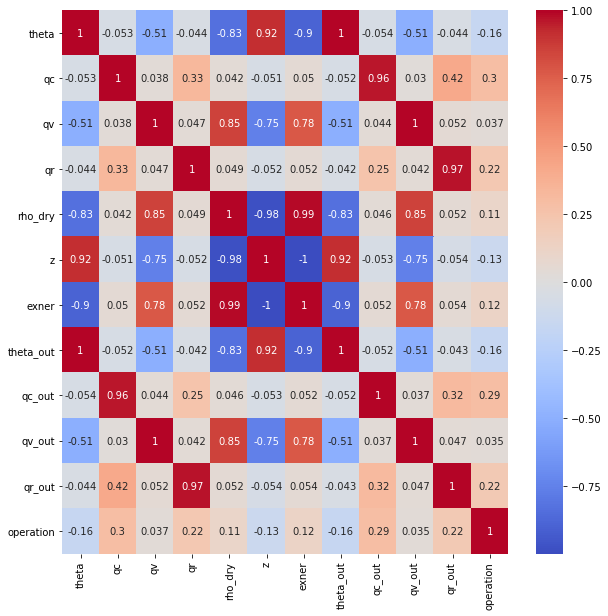

In [15]:
#creates correlation matrix for whole dataset data
plt.figure(figsize=(10,10))
sb.heatmap(df.corr(),annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='z', ylabel='theta_out'>

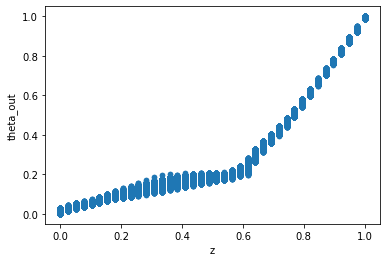

In [16]:
#Scatter plots of outputs vs height
df.plot.scatter(x='z',y='theta_out')

<AxesSubplot:xlabel='z', ylabel='qc_out'>

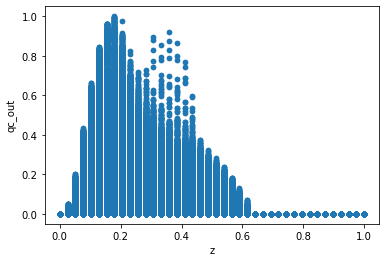

In [17]:
df.plot.scatter(x='z',y='qc_out')

<AxesSubplot:xlabel='z', ylabel='qv_out'>

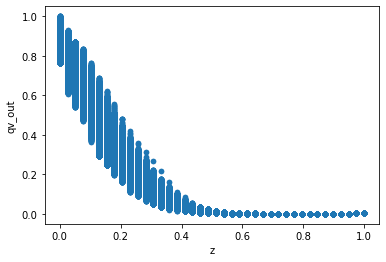

In [18]:
df.plot.scatter(x='z',y='qv_out')

<AxesSubplot:xlabel='z', ylabel='qr_out'>

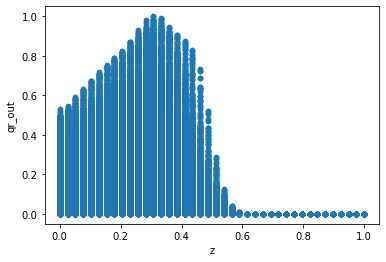

In [19]:
df.plot.scatter(x='z',y='qr_out')

### The classification models are defined here. We use sklearn models for the baseline and DNN models. The sklearn models used are: logistic regression, Stochastic Gradient Descent Classifier, Support Vector Classifier, Decision Tree Classifier, and Multilayer Perceptron Classifier. Each function prints the test accuracy, plots the confusion matrix, and returns the classifier.

In [20]:
#Classification Models

def logRegress(xtrain,ytrain,xtest,ytest,tol,verb):
    #function to perform logistic regression on xtrain/ytrain,
    #tests on xtest/ytest, and print scores
    #takes in train/test sets, stopping tolerence, and boolean
    #for verbose training
    #returns logistic regression model 
    
    print('-----Logistic Regression-----')
    lr=LogisticRegression(dual=False,tol=tol,random_state=0,verbose=verb)
    lr.fit(xtrain,ytrain)
    print('accuracy score=',lr.score(xtest,ytest))
    plot_confusion_matrix(lr,xtest,ytest,normalize='all')
        
    return lr

def sgdClass(xtrain,ytrain,xtest,ytest,verb,es):
    #function to perform stochastic gradient decent classification
    #on xtrain/ytrain, test on xtest/ytest, and print scores
    #takes in train/test sets, boolean
    #for verbose training, and boolean for early stopping
    #returns the sgd model
    
    print('-----SGD Classifier-----')
    sgd=SGDClassifier(verbose=verb,random_state=0,early_stopping=es)
    sgd.fit(xtrain,ytrain)
    print('accuracy score=',sgd.score(xtest,ytest))
    plot_confusion_matrix(sgd,xtest,ytest,normalize='all')
        
    return sgd

def SVC(xtrain,ytrain,xtest,ytest,tol,verb):
    #funtion to perform support vector classification on xtrain/train, 
    #test on xtest/ytest, and print scores
    #takes in train/test sets, stopping tolerance, and boolean for vebose training
    #returns the SVC model
    
    print('-----SVC-----')
    svc=LinearSVC(dual=False,tol=tol,verbose=verb,random_state=0)
    svc.fit(xtrain,ytrain)
    print('accuracy score=',svc.score(xtest,ytest))
    plot_confusion_matrix(svc,xtest,ytest,normalize='all')
    
    
    return svc

def dtClass(xtrain,ytrain,xtest,ytest,minSplit):
    #function to perform decision tree classification on xtrain/ytrain,
    #test on xtest/ytest, and print scores
    #takes in train/tests sets and int to indicate the minimum samples needed to split
    #return decision tree model
    
    print('-----DT Classifier-----')
    dtc=DecisionTreeClassifier(min_samples_split=minSplit,random_state=0)
    dtc.fit(xtrain,ytrain)
    print('accuracy score=',dtc.score(xtest,ytest))
    plot_confusion_matrix(dtc,xtest,ytest,normalize='all')
        
    return dtc

def nnClass(xtrain,ytrain,xtest,ytest,layers,act,lr,tol,es,verb):
    #function to perform classification with neural network, 
    #test on xtest/ytest, and print scores
    #takes in train/test sets, array for number/size of layers,
    #a string for the activation function, learning rate, stopping tolerence,
    #and two booleans for early stopping and verbose training
    #Returns the NN model
    
    print('-----NN Classifier-----')
    print('Number of hidden layers:',len(layers),'-----hidden layer sizes:',layers)
    mlp=MLPClassifier(hidden_layer_sizes=layers,activation=act,learning_rate_init=lr,tol=tol,early_stopping=es,verbose=verb)
    mlp.fit(xtrain1,ytrain1)
    print('accuracy score=',mlp.score(xtest1,ytest1))
    plot_confusion_matrix(mlp,xtest1,ytest1,normalize='all')
    
    return mlp

### The following defines the regression models. Again, sklearn models are used: Linear Regression, Decision Tree Regression, and Mulitlayer Perceptron Regressor. Each function prints the mean absolute error and returns the regressor.

In [21]:
#Regression Models

def linRegress(xtrain,ytrain,xtest,ytest):
    #function to perform linear regression on xtrain/ytrain,
    #test on xtest/ytest, and print results
    #takes in train/test set, returns linear regession model
    
    linReg=LinearRegression()
    linReg.fit(xtrain,ytrain)
    ypred=linReg.predict(xtest)
   
    print('-----Linear Regressor-----')
    print('# features:', linReg.rank_,)
    print('MAE test scores ----- AVG=',mean_absolute_error(ytest,ypred),'----- by variable:',mean_absolute_error(ytest,ypred,multioutput='raw_values'))
    
    return linReg

def dtRegress(xtrain,ytrain,xtest,ytest,minSplit,crit):
    #function to perform decision tree regression on xtrain/ytrain,
    #test on xtest/ytest, and print the results
    #Takes in train/test datasets, int for the minimum samples to split,
    #and string for split criterion ('mse' or 'mae')
    #returns the decision tree model 
    
    dtr=DecisionTreeRegressor(min_samples_split=20,random_state=0,criterion=crit)
    dtr.fit(xtrain,ytrain)
    ypred=dtr.predict(xtest)
    
    print('-----DT Regressor-----')
    print('# features:',dtr.n_features_,'-----','# outputs:',dtr.n_outputs_)
    print('MAE test scores ----- AVG=',mean_absolute_error(ytest,ypred),'----- by variable:',mean_absolute_error(ytest,ypred,multioutput='raw_values'))

    return dtr

def nnRegress(xtrain,ytrain,xtest,ytest,layers,act,lr,tol,es,verb):
    #function to perform regression on xtrain/ytrain using neural network,
    #test on xtest/ytest, and print results
    #Takes in train/test sets, array for number of layers and nodes, activation function,
    #learnig rate, stopping tolerance, boolean for early stopping, and boolean for verbose
    #Returns the nn model
    
    print('-----NN Regressor-----')
    print('Number of hidden layers:', len(layers),'-----hidden layer sizes:',layers)
    mlp=MLPRegressor(hidden_layer_sizes=layers,tol=tol,early_stopping=es,verbose=verb)
    mlp.fit(xtrain,ytrain)
    ypred=mlp.predict(xtest)    
    
    print('# of Iterations:',mlp.n_iter_,'-----','Final Training Loss=',mlp.loss_)
    print('MAE test scores ----- AVG=',mean_absolute_error(ytest,ypred),'----- by variable:',mean_absolute_error(ytest,ypred,multioutput='raw_values'))
    
    return mlp

### We can now run the classification models. The DNNs are defined using the nnClass function. The first DNN is a ten layer network with 64 nodes per layer (10x64). The second DNN is a six layer network with 100 nodes per layer (6x100).

In [ ]:
#Running Classification Models

#inputs for various models
verboseTrain=True
earlyStop=True
stopTol=1e-5
minSplit=20

#Inputs for the DNNs
dnnLayers1=[64,64,64,64,64,64,64,64,64,64]
dnnLayers2=[100,100,100,100,100,100]
act1='relu'
act2='relu'
lr1=1e-4
lr2=1e-4


logReg=logRegress(xtrain1,ytrain1,xtest1,ytest1,stopTol,verboseTrain)
sgd=sgdClass(xtrain1,ytrain1,xtest1,ytest1,verboseTrain,earlyStop)
svc=SVC(xtrain1,ytrain1,xtest1,ytest1,stopTol,verboseTrain)
dtc=dtClass(xtrain1,ytrain1,xtest1,ytest1,minSplit)
p100=nnClass(xtrain1,ytrain1,xtest1,ytest1,[100],'relu',1e-4,stopTol,earlyStop,verboseTrain)
dnn1=nnClass(xtrain1,ytrain1,xtest1,ytest1,dnnLayers1,act1,lr1,stopTol,earlyStop,verboseTrain)
dnn2=nnClass(xtrain1,ytrain1,xtest1,ytest1,dnnLayers2,act2,lr2,stopTol,earlyStop,verboseTrain)

-----Logistic Regression-----


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


accuracy score= 0.7675435419444222
-----SGD Classifier-----
-- Epoch 1
Norm: 23.23, NNZs: 7, Bias: -0.687607, T: 3217981, Avg. loss: 0.506745
Total training time: 0.63 seconds.
-- Epoch 2
Norm: 23.28, NNZs: 7, Bias: -0.854416, T: 6435962, Avg. loss: 0.496043
Total training time: 1.69 seconds.
-- Epoch 3
Norm: 23.31, NNZs: 7, Bias: -0.930736, T: 9653943, Avg. loss: 0.495517
Total training time: 2.75 seconds.
-- Epoch 4
Norm: 23.32, NNZs: 7, Bias: -0.971318, T: 12871924, Avg. loss: 0.495255
Total training time: 3.82 seconds.
-- Epoch 5
Norm: 23.33, NNZs: 7, Bias: -0.991193, T: 16089905, Avg. loss: 0.495145
Total training time: 4.88 seconds.
-- Epoch 6
Norm: 23.34, NNZs: 7, Bias: -1.008831, T: 19307886, Avg. loss: 0.495058
Total training time: 5.94 seconds.
Convergence after 6 epochs took 6.38 seconds
accuracy score= 0.7213087153062603
-----SVC-----
[LibLinear]accuracy score= 0.7751350356603778
-----DT Classifier-----
accuracy score= 0.9113159785509142
-----NN Classifier-----
Number of hi

### The following prepares the data for the regression models. To maintain at least 50% operation samples in the data, the value given to 'mixSamples' should be no greater than 1.

In [ ]:
#Prepare data for regression models

mixDF,opDF,nopDF=mixSamples(df,.5)

#Split data into input and target values
x2=mixDF[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y2=mixDF[['theta_out','qc_out','qv_out','qr_out']].copy()

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size=0.30, random_state=10)


### We can now run the regression models calling the functions defined above. The DNNs are defined using the 'nnRegress' function. The same DNN architectures used for classification, 10x64 and 6x100, are used for regression.

In [ ]:
#Running Regression Models

verboseTrain=True
earlyStop=True
stopTol=1e-5
minSplit=20
dtCrit='mse'

dnnLayers1=[64,64,64,64,64,64,64,64,64,64]
dnnLayers2=[100,100,100,100,100,100]
act1='relu'
act2='relu'
lr1=1e-4
lr2=1e-4

lr=linRegress(xtrain2,ytrain2,xtest2,ytest2)
dtr=dtRegress(xtrain2,ytrain2,xtest2,ytest2,minSplit,dtCrit)
p100Reg=nnRegress(xtrain2,ytrain2,xtest2,ytest2,[100],'relu',1e-4,stopTol,earlyStop,verboseTrain)
dnnReg1=nnRegress(xtrain2,ytrain2,xtest2,ytest2,dnnLayers1,'relu',1e-4,stopTol,earlyStop,verboseTrain)
dnnReg2=nnRegress(xtrain2,ytrain2,xtest2,ytest2,dnnLayers2,'relu',1e-4,stopTol,earlyStop,verboseTrain)

### Training and testing the classifiers on datasets with a varying number of no-op samples should lead to results similar to the plot shown which displays the % of no-op samples vs. the classification accuracy. For this plot the models were trained/tested on datasets with 50%, 75%, and 90% no-op samples.
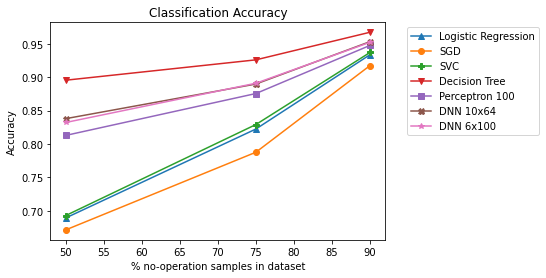

### Here are the confusion matrices for the decision tree classifier and DNNs for each dataset

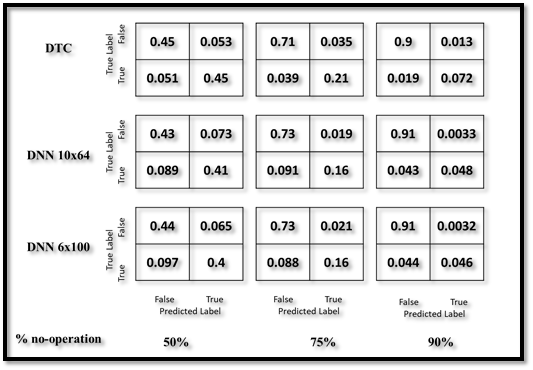

### Similarly, training and testing the regressors on varying datasets should lead to results similar to those in the plot below which displays the % of no-op samples vs. The test MAE scores. Here, datasets with 0%, 10%, 33%, and 50% no-op samples were used.
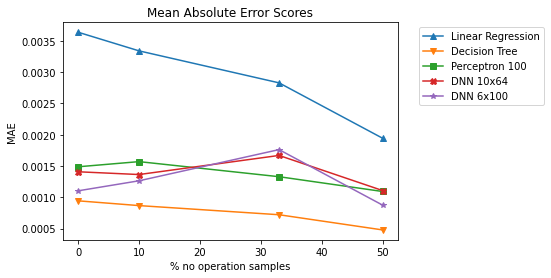

### The last table displays the MAE by variable for the Decision Tree regressor and DNNs
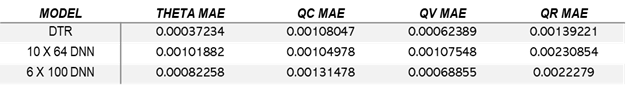

### Please refer to the report for a more detailed explanation of the results.